# Вебинар 6. Двухуровневые модели рекомендаций


### Зачем 2 уровня?
- Классические модели классификации (lightgbm) зачастую работают лучше, чем рекоммендательные модели (als, lightfm)
- Данных много, предсказаний много (# items * # users) --> с таким объемом lightgbm не справляется
- Но рекомендательные модели справляются!

Отбираем top-N (200) *кандидатов* с помощью простой модели (als) --> переранжируем их сложной моделью (lightgbm)
и выберем top-k (10).

---

### Применение в бизнесе

Если вы еще не прочитали [статью](https://habr.com/ru/company/hh/blog/347276/) о рекомендательных системах и поиске в hh.ru, то обязательно прочитайте

- 2-ух уровневая система применяется во многих компаниях
- Зачастую уровней > 2
- Идем от более простых эвристик/моделей к более сложным
- Фичи из моделей первого уровня (embeddings, biases из ALS) можно использовать в последующих моделях

Также решения на основе 2-ух уровневых рекомендаций заняли все топ-10 мест в соревновании X5 Retail hero.

- [Презентация](https://github.com/aprotopopov/retailhero_recommender/blob/master/slides/retailhero_recommender.pdf) и [Код](https://github.com/aprotopopov/retailhero_recommender) решения 2-ого места
- [Код](https://vk.com/away.php?utf=1&to=https%3A%2F%2Fgithub.com%2Fmike-chesnokov%2Fx5_retailhero_2020_recs) решения 9-ого места

![hh_recsys.png](attachment:hh_recsys.png)

### Как отбирать кандидатов?

Вариантов множество. Тут нам поможет *MainRecommender*. Пока в нем реализованы далеко не все возможные способы генерации кандидатов

- Генерируем топ-k кандидатов
- Качество кандидатов измеряем через **recall@k**
- recall@k показывает какую долю из купленных товаров мы смогли выявить (рекомендовать) нашей моделью

----

# Практическая часть

Код для src, utils, metrics вы можете скачать с [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [1]:
!pip install lightfm
!pip install implicit

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%load_ext autoreload
%autoreload 2

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
sys.path.append('/content/drive/MyDrive/Rec_systems')
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [66]:
import pandas as pd
import numpy as np

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import ItemItemRecommender  # нужен для одного трюка
from implicit.nearest_neighbours import bm25_weight, tfidf_weight


class MainRecommender:
    """Рекоммендации, которые можно получить из ALS

    Input
    -----
    user_item_matrix: pd.DataFrame
        Матрица взаимодействий user-item
    """

    def __init__(self, data, weighting=True, fake_id=999999, model_attrs=None):

        # Топ покупок каждого юзера
        self.top_purchases = data.groupby(['user_id', 'item_id'])['quantity'].count().reset_index()
        self.top_purchases.sort_values('quantity', ascending=False, inplace=True)
        if fake_id is not None:
            self.top_purchases = self.top_purchases[self.top_purchases['item_id'] != fake_id]

        # Топ покупок по всему датасету
        self.overall_top_purchases = data.groupby('item_id')['quantity'].count().reset_index()
        self.overall_top_purchases.sort_values('quantity', ascending=False, inplace=True)
        if fake_id is not None:
            self.overall_top_purchases = self.overall_top_purchases[self.overall_top_purchases['item_id'] != fake_id]
        self.overall_top_purchases = self.overall_top_purchases.item_id.tolist()

        self.user_item_matrix = self._prepare_matrix(data)  # pd.DataFrame
        self.id_to_itemid, self.id_to_userid, \
            self.itemid_to_id, self.userid_to_id = self._prepare_dicts(self.user_item_matrix)
        self.user_item_matrix = csr_matrix(self.user_item_matrix).tocsr()
        self.user_item_matrix_for_pred = self.user_item_matrix
        if weighting == 'bm25':
            self.user_item_matrix = bm25_weight(self.user_item_matrix.T).T.tocsr()
        elif weighting =='tfidf':
            self.user_item_matrix = tfidf_weight(self.user_item_matrix.T).T.tocsr()
        self.fake_id = fake_id
        self.model = self.fit(self.user_item_matrix, model_attrs)
        self.own_recommender = self.fit_own_recommender(self.user_item_matrix)

    @staticmethod
    def _prepare_matrix(data):
        """Готовит user-item матрицу"""
        user_item_matrix = pd.pivot_table(data,
                                          index='user_id', columns='item_id',
                                          values='quantity',  # Можно пробовать другие варианты
                                          aggfunc='count',
                                          fill_value=0
                                          )

        user_item_matrix = user_item_matrix.astype(float)  # необходимый тип матрицы для implicit

        return user_item_matrix

    @staticmethod
    def _prepare_dicts(user_item_matrix):
        """Подготавливает вспомогательные словари"""

        userids = user_item_matrix.index.values
        itemids = user_item_matrix.columns.values

        matrix_userids = np.arange(len(userids))
        matrix_itemids = np.arange(len(itemids))

        id_to_itemid = dict(zip(matrix_itemids, itemids))
        id_to_userid = dict(zip(matrix_userids, userids))

        itemid_to_id = dict(zip(itemids, matrix_itemids))
        userid_to_id = dict(zip(userids, matrix_userids))

        return id_to_itemid, id_to_userid, itemid_to_id, userid_to_id

    @staticmethod
    def fit_own_recommender(user_item_matrix):
        """Обучает модель, которая рекомендует товары, среди товаров, купленных юзером"""

        own_recommender = ItemItemRecommender(K=1, num_threads=4)
        own_recommender.fit(user_item_matrix)

        return own_recommender

    @staticmethod
    def fit(user_item_matrix, model_attrs, n_factors=20, regularization=0.001, iterations=15, num_threads=4):
        """Обучает ALS"""
        model = AlternatingLeastSquares(factors=n_factors,
                                        regularization=regularization,
                                        iterations=iterations,
                                        num_threads=num_threads)
        if model_attrs is not None:
            for k, v in model_attrs.items():
                setattr(model, k, v)

        model.fit(user_item_matrix, show_progress=False)

        return model

    def get_recall_at_k(self, val_data, k=5):
      result = val_data.groupby('user_id')['item_id'].unique().reset_index()
      result.columns=['user_id', 'actual']
      result = result[result['user_id'].isin(self.userid_to_id.keys())]
      result['pred'] = result.apply(lambda x: self.get_als_recommendations(x['user_id'], N=k), axis=1)
      recall_value = result.apply(lambda x: recall_at_k(x['pred'], x['actual'], k=k), axis=1).mean()

      return recall_value

    def get_own_recall_at_k(self, val_data, k=5):
      result = val_data.groupby('user_id')['item_id'].unique().reset_index()
      result.columns=['user_id', 'actual']
      result = result[result['user_id'].isin(self.userid_to_id.keys())]
      result['pred'] = result.apply(lambda x: self.get_own_recommendations(x['user_id'], N=k), axis=1)
      recall_value = result.apply(lambda x: recall_at_k(x['pred'], x['actual'], k=k), axis=1).mean()

      return recall_value

    def _update_dict(self, user_id):
        """Если появился новыю user / item, то нужно обновить словари"""

        if user_id not in self.userid_to_id.keys():

            max_id = max(list(self.userid_to_id.values()))
            max_id += 1

            self.userid_to_id.update({user_id: max_id})
            self.id_to_userid.update({max_id: user_id})

    def _get_similar_item(self, item_id):
        """Находит товар, похожий на item_id"""
        recs = self.model.similar_items(self.itemid_to_id[item_id], N=2)  # Товар похож на себя -> рекомендуем 2 товара
        top_rec = recs[0][1]  # И берем второй (не товар из аргумента метода)
        return self.id_to_itemid[top_rec]

    def _extend_with_top_popular(self, recommendations, N=5):
        """Если кол-во рекоммендаций < N, то дополняем их топ-популярными"""

        if len(recommendations) < N:
            recommendations.extend(self.overall_top_purchases[:N])
            recommendations = recommendations[:N]

        return recommendations

    def _get_recommendations(self, user, model, N=5):
        """Рекомендации через стардартные библиотеки implicit"""

        self._update_dict(user_id=user)
        filter_items = [] if self.fake_id is None else [self.itemid_to_id[self.fake_id]]
        res = model.recommend(userid=self.userid_to_id[user],
                                        user_items=self.user_item_matrix_for_pred[self.userid_to_id[user]],
                                        N=N,
                                        filter_already_liked_items=False,
                                        filter_items=filter_items,
                                        recalculate_user=True)
        mask = res[1].argsort()[::-1]
        res = [self.id_to_itemid[rec] for rec in res[0][mask]]
        res = self._extend_with_top_popular(res, N=N)

        assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
        return res

    def get_als_recommendations(self, user, N=5):
        """Рекомендации через стардартные библиотеки implicit"""

        self._update_dict(user_id=user)
        return self._get_recommendations(user, model=self.model, N=N)

    def get_own_recommendations(self, user, N=5):
        """Рекомендуем товары среди тех, которые юзер уже купил"""

        self._update_dict(user_id=user)
        return self._get_recommendations(user, model=self.own_recommender, N=N)

    def get_similar_items_recommendation(self, user, N=5):
        """Рекомендуем товары, похожие на топ-N купленных юзером товаров"""

        top_users_purchases = self.top_purchases[self.top_purchases['user_id'] == user].head(N)

        res = top_users_purchases['item_id'].apply(lambda x: self._get_similar_item(x)).tolist()
        res = self._extend_with_top_popular(res, N=N)

        assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
        return res

    def get_similar_users_recommendation(self, user, N=5):
        """Рекомендуем топ-N товаров, среди купленных похожими юзерами"""

        res = []

        # Находим топ-N похожих пользователей
        similar_users = self.model.similar_users(self.userid_to_id[user], N=N+1)
        similar_users = similar_users[0]
        similar_users = similar_users[1:]   # удалим юзера из запроса

        for user in similar_users:
            res.extend(self.get_own_recommendations(user, N=1))

        res = self._extend_with_top_popular(res, N=N)

        assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
        return res

In [16]:
data = pd.read_csv('/content/drive/MyDrive/Rec_systems/retail_train.csv')
item_features = pd.read_csv('/content/drive/MyDrive/Rec_systems/product.csv')
user_features = pd.read_csv('/content/drive/MyDrive/Rec_systems/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель --
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [17]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [31]:
param_grid = {
              # 'n_factors': [10, 20, 30],
              # 'regularization': [0.01, 0.05, 0.001],
              # 'iterations':[5, 10, 15],
              'n_factors': [10, 20],
              'num_threads': [0]
              }

params_dict = {}

keys, values = zip(*param_grid.items())
for v in itertools.product(*values):
    params = dict(zip(keys, v))
    recommender = MainRecommender(data_train_lvl_1, model_attrs=params)
    recall_value = round(recommender.get_recall_at_k(recommender, data_val_lvl_1, k=5), 4)
    params_dict[str(params)] = recall_value

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

In [32]:
params_dict

{"{'n_factors': 10, 'num_threads': 0}": 0.0202,
 "{'n_factors': 20, 'num_threads': 0}": 0.0202}

In [33]:
recommender = MainRecommender(data_train_lvl_1, model_attrs={
    'n_factors':20,
    'regularization':0.01,
    'iterations':5,
    'num_threads':0
})

  0%|          | 0/5001 [00:00<?, ?it/s]

In [34]:
sorted(params_dict, reverse=True)[0]

"{'n_factors': 20, 'num_threads': 0}"

### Варианты, как получить кандидатов

Можно потом все эти варианты соединить в один

(!) Если модель рекомендует < N товаров, то рекомендации дополняются топ-популярными товарами до N

In [35]:
test_user = 2375

In [36]:
recommender.get_als_recommendations(test_user, N=5)

[1106523, 1029743, 1044078, 899624, 844179]

In [37]:
recommender.get_own_recommendations(test_user, N=5)

[1029743, 1106523, 5569230, 916122, 844179]

In [38]:
recommender.get_similar_items_recommendation(test_user, N=5)

[1046545, 1029743, 841220, 945662, 892768]

In [39]:
recommender.get_similar_users_recommendation(test_user, N=5)

[1029743, 1029743, 1029743, 1029743, 1029743]

### Измеряем recall@k

Это будет в ДЗ:

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [48]:
# Блок подсчёта recall

def get_recall_at_k(model, val_data, k=5):
  result = val_data.groupby('user_id')['item_id'].unique().reset_index()
  result.columns=['user_id', 'actual']
  result = result[result['user_id'].isin(model.userid_to_id.keys())]
  result['pred'] = result.apply(lambda x: model.get_als_recommendations(x['user_id'], N=k), axis=1)
  recall_value = result.apply(lambda x: recall_at_k(x['pred'], x['actual'], k=k), axis=1).mean()

  return recall_value

In [46]:
def get_own_recall_at_k(model, val_data, k=5):
  result = val_data.groupby('user_id')['item_id'].unique().reset_index()
  result.columns=['user_id', 'actual']
  result = result[result['user_id'].isin(model.userid_to_id.keys())]
  result['pred'] = result.apply(lambda x: model.get_own_recommendations(x['user_id'], N=k), axis=1)
  recall_value = result.apply(lambda x: recall_at_k(x['pred'], x['actual'], k=k), axis=1).mean()

  return recall_value

In [67]:
lvl_1_recommender = MainRecommender(data_train_lvl_1,
                                    model_attrs={'n_factors': 20,
                                                 'regularization': 0.05,
                                                 'iterations': 5,
                                                 'num_threads': 0})
print(lvl_1_recommender.get_recall_at_k(data_val_lvl_1, k=50))
print(lvl_1_recommender.get_own_recall_at_k(data_val_lvl_1, k=50))

  0%|          | 0/5001 [00:00<?, ?it/s]

0.06301371996102331
0.0432368435310526


Cвязка own_recommendations + top показывает себя хуже по полноте, чем модель. Это не слишком логично и я ожидал другого результата, возможно в расчётах ошибка.

In [68]:
import matplotlib.pyplot as plt

k_list = pd.DataFrame([20, 50, 100, 200, 500])

k_list.columns = ['k']

In [69]:
k_list['recall'] = k_list.apply(lambda x: lvl_1_recommender.get_recall_at_k(data_val_lvl_1, k=x['k']), axis=1)

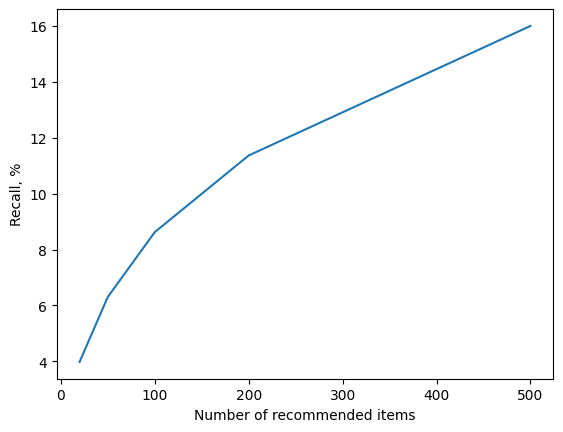

In [70]:
plt.plot(k_list['k'], k_list['recall']*100)
plt.xlabel('Number of recommended items')
plt.ylabel('Recall, %')
plt.show()

Полнота увеличивается с ростом количества рекоммендуемых объектов. Чем больше мы предлагаем, тем выше шанс, что мы угадаем предмет, который купил пользователь.

Если бы это была одноуровневая модель, то К должен быть той же размерности, что в итоге будет видеть пользователь. Если модель двухуровневая, то К должен быть максимально большой при разумном времени обучения второй модели.

### Обучаем модель 2-ого уровня на выбранных кандидатах

- Обучаем на data_train_lvl_2
- Обучаем *только* на выбранных кандидатах
- Я *для примера* сгенерирую топ-50 кадидиатов через get_own_recommendations
- (!) Если юзер купил < 50 товаров, то get_own_recommendations дополнит рекоммендации топ-популярными

In [108]:
class LGBMRecommender():
  def __init__(self, data, candidates, user_features, item_features):

    self.data = data
    self.candidates = candidates
    self.user_features = user_features
    self.item_features = item_features

    self.X_train, self.y_train = self._prepare_dataset(self.data, self.candidates)

    self.cat_feats = self.X_train.columns[2:].tolist()
    self.X_train[self.cat_feats] = self.X_train[self.cat_feats].astype('category')
    self.model = self.fit(self.X_train, self.y_train, self.cat_feats)

  def _prepare_dataset(self, data, candidates):
    s = candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
    s.name = 'item_id'
    candidates = candidates.drop('candidates', axis=1).join(s)

    targets = data[['user_id', 'item_id']].copy()
    targets['target'] = 1  # тут только покупки

    targets = candidates.merge(targets, on=['user_id', 'item_id'], how='left')

    targets['target'].fillna(0, inplace= True)
    targets = targets.merge(self.item_features, on='item_id', how='left')
    targets = targets.merge(self.user_features, on='user_id', how='left')

    X_train = targets.drop('target', axis=1)
    y_train = targets[['target']]

    return X_train, y_train

  @staticmethod
  def fit(X_train, y_train, cat_feats):
    model = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats)
    model.fit(X_train, y_train)
    return model

  def _get_recommendations(self, data, user_id, N=5):
    one_user = data[(data['user_id'] == user_id)]
    one_user['preds'] = self.model.predict_proba(data[(data['user_id'] == user_id)])[:,1]
    one_user = one_user[['item_id', 'preds']]
    recs = one_user.sort_values(by='preds', ascending=False)[:N]['item_id'].tolist()
    return recs

  def get_recall_at_k(self, val_data, candidates, k=5):
    val_data = self._prepare_dataset(val_data, candidates)[0]
    result = val_data.groupby('user_id')['item_id'].unique().reset_index()
    result.columns=['user_id', 'actual']
    result = result[result['user_id'].isin(self.data['user_id'])]
    result['pred'] = result.apply(lambda x: self._get_recommendations(self.X_train, x['user_id'], N=k), axis=1)
    recall_value = result.apply(lambda x: recall_at_k(x['pred'], x['actual'], k=k), axis=1).mean()

    return recall_value



In [ ]:
# -- давние покупки -- | -- 6 недель -- | -- 3 недель --

In [82]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Пока только warm start
users_lvl_1 = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(users_lvl_1)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))

In [93]:
val_users_lvl_2 = pd.DataFrame(data_val_lvl_2['user_id'].unique())
val_users_lvl_2.columns = ['user_id']

# Пока только warm start
users_lvl_1 = data_train_lvl_1['user_id'].unique()
val_users_lvl_2 = val_users_lvl_2[val_users_lvl_2['user_id'].isin(users_lvl_1)]

val_users_lvl_2['candidates'] = val_users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))

In [109]:
lvl_2_recommender = LGBMRecommender(data_train_lvl_2, users_lvl_2, user_features, item_features)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


In [110]:
lvl_2_recommender._get_recommendations(lvl_2_recommender.X_train, 255, N=10)

<ipython-input-108-526848a8c8f5>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_user['preds'] = self.model.predict_proba(data[(data['user_id'] == user_id)])[:,1]


[1106523,
 1029743,
 1126899,
 1070820,
 1044078,
 899624,
 1004906,
 916122,
 844179,
 854852]

In [111]:
lvl_2_recommender.get_recall_at_k(data_val_lvl_2, val_users_lvl_2, k=5)

0.08811488250652742

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1029743,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1106523,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
2,2070,5569230,1208,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
3,2070,916122,4314,MEAT,National,CHICKEN,CHICKEN BREAST BONELESS,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
4,2070,844179,2852,MEAT,National,BEEF,PRIMAL,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110193,1745,1122358,69,GROCERY,Private,REFRGRATD JUICES/DRNKS,DAIRY CASE 100% PURE JUICE - O,1 GA,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown
110194,1745,1132771,3787,DELI,National,CHEESES,CHEESE: NATURAL BULK,,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown
110195,1745,823704,2082,MEAT-PCKGD,National,BREAKFAST SAUSAGE/SANDWICHES,ROLLS - PORK,16 OZ,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown
110196,1745,854405,397,MEAT-PCKGD,National,MEAT - MISC,BREAST - BONELESS(IQF),40 OZ,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown


In [ ]:
item_features.head(5)

In [ ]:
user_features.head(5)

In [47]:
users_lvl_2.head(2)

,user_id,candidates
0,2070,"[1029743, 1106523, 5569230, 916122, 844179, 10..."
1,2021,"[1029743, 1106523, 5569230, 916122, 844179, 10..."


In [48]:
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
users_lvl_2['flag'] = 1

users_lvl_2.head(4)

,user_id,item_id,flag
0,2070,1029743,1
0,2070,1106523,1
0,2070,5569230,1
0,2070,916122,1


In [49]:
users_lvl_2.shape[0]

107550

In [50]:
users_lvl_2['user_id'].nunique()

2151

In [51]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки

targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2.drop('flag', axis=1, inplace=True)

In [52]:
targets_lvl_2.head(3)

,user_id,item_id,target
0,2070,1029743,0.0
1,2070,1106523,0.0
2,2070,5569230,0.0


(!) На каждого юзера 50 item_id-кандидатов

In [53]:
targets_lvl_2['target'].mean()

0.07157117189059693

![hard_choice.png](attachment:hard_choice.png)

Слайд из [презентации](https://github.com/aprotopopov/retailhero_recommender/blob/master/slides/retailhero_recommender.pdf) решения 2-ого места X5 Retail Hero

- Пока для простоты обучения выберем LightGBM c loss = binary. Это классическая бинарная классификация
- Это пример *без* генерации фич

In [54]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [55]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [56]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1029743,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1106523,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


**Фичи user_id:**
    - Средний чек
    - Средняя сумма покупки 1 товара в каждой категории
    - Кол-во покупок в каждой категории
    - Частотность покупок раз/месяц
    - Долю покупок в выходные
    - Долю покупок утром/днем/вечером

**Фичи item_id**:
    - Кол-во покупок в неделю
    - Среднее ол-во покупок 1 товара в категории в неделю
    - (Кол-во покупок в неделю) / (Среднее ол-во покупок 1 товара в категории в неделю)
    - Цена (Можно посчитать из retil_train.csv)
    - Цена / Средняя цена товара в категории
    
**Фичи пары user_id - item_id**
    - (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
    - (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
    - (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

In [57]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [58]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

In [59]:
lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats)
lgb.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


LGBMClassifier(categorical_column=['manufacturer', 'department', 'brand',
                                   'commodity_desc', 'sub_commodity_desc',
                                   'curr_size_of_product', 'age_desc',
                                   'marital_status_code', 'income_desc',
                                   'homeowner_desc', 'hh_comp_desc',
                                   'household_size_desc', 'kid_category_desc'],
               max_depth=7, objective='binary')

In [60]:
train_preds = lgb.predict_proba(X_train)[:,1]

In [86]:
one_user = X_train[(X_train['user_id'] == 2070)]

In [87]:
one_user['preds'] = lgb.predict_proba(X_train[(X_train['user_id'] == 2070)])[:,1]

<ipython-input-87-3f511e0d6e3e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_user['preds'] = lgb.predict_proba(X_train[(X_train['user_id'] == 2070)])[:,1]


In [89]:
one_user = one_user[['item_id', 'preds']]

In [94]:
one_user.sort_values(by='preds', ascending=False)[:3]['item_id']

0    1029743
1    1106523
7    1070820
Name: item_id, dtype: int64

Берем топ-k предсказаний, ранжированных по вероятности, для каждого юзера

In [61]:
final_recs = pd.concat([targets_lvl_2, pd.DataFrame(train_preds, columns=['prediction'])], axis=1)

In [62]:
a = final_recs[['user_id', 'item_id', 'prediction']].groupby('user_id')['item_id'].apply(list)

In [63]:
a = pd.DataFrame(a).reset_index()

In [65]:
result_lvl_2 = data_train_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2 = result_lvl_2[result_lvl_2['user_id'].isin(users_lvl_1)]

In [66]:
result_lvl_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2151 entries, 0 to 2153
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  2151 non-null   int64 
 1   item_id  2151 non-null   object
dtypes: int64(1), object(1)
memory usage: 50.4+ KB


In [67]:
result_lvl_2 = pd.merge(result_lvl_2, a, on='user_id', how='left')

In [68]:
result_lvl_2.columns = ['user_id', 'actual', 'preds']

In [69]:
result_lvl_2

,user_id,actual,preds
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[1029743, 1106523, 5569230, 916122, 844179, 10..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[1029743, 1106523, 5569230, 916122, 844179, 10..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67...","[1029743, 1106523, 5569230, 916122, 844179, 10..."
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[1029743, 1106523, 5569230, 916122, 844179, 10..."
4,7,"[836281, 843306, 845294, 914190, 920456, 93886...","[1029743, 1106523, 5569230, 916122, 844179, 10..."
...,...,...,...
2146,2496,"[831509, 867188, 1013623, 1048851, 5592734, 16...","[1029743, 1106523, 1106523, 5569230, 916122, 9..."
2147,2497,"[820291, 824759, 838797, 859010, 859075, 86077...","[1029743, 1106523, 5569230, 916122, 844179, 10..."
2148,2498,"[865511, 962991, 1076374, 1102358, 5564901, 15...","[1029743, 1106523, 1106523, 5569230, 916122, 8..."
2149,2499,"[861282, 921744, 1050968, 13842089, 828837, 86...","[1029743, 1106523, 5569230, 916122, 844179, 10..."


In [70]:
recall_value = result_lvl_2.apply(lambda x: recall_at_k(x['preds'], x['actual'], k=5), axis=1).mean()

In [71]:
recall_value

0.014778968942751776

In [72]:
precision_value = result_lvl_2.apply(lambda x: precision_at_k(x['preds'], x['actual'], k=5), axis=1).mean()

In [73]:
precision_value

0.11650395165039516